In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.optim import AdamW # Import AdamW from torch.optim
from torch.utils.data import Dataset, DataLoader,ConcatDataset
import os
from tqdm.auto import tqdm
import zipfile
from PIL import Image
from io import BytesIO
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

from itertools import chain
import math
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from datetime import datetime
import json
from pathlib import Path

In [2]:
# Ruta principal
dataset_path = "/home/mitchellmirano/Desktop/MitchellProjects/H vs J phase diagram/DATASET"
results_path = "/home/mitchellmirano/Desktop/MitchellProjects/TesisMaestria/results/SkyrmionClassifier"

In [3]:
# Función "collate" personalizada que utiliza el feature extractor
model2_repo_id = 'google/vit-base-patch16-224-in21k'
model2_feature_extractor = ViTFeatureExtractor.from_pretrained(model2_repo_id)

# Definir la transformación para las imágenes
rgb_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convertir imágenes de escala de grises a 3 canales (RGB)                 # Redimensionar al tamaño requerido por ViT
])

def model2_collate_fn(batch):
    # Separa las imágenes y etiquetas
    images, labels = zip(*batch)
    # Aplica el feature extractor a la lista de imágenes (se espera que sean objetos PIL.Image)
    inputs = model2_feature_extractor(list(images), return_tensors="pt")
    inputs["labels"] = torch.tensor(labels)
    return inputs

/home/mitchellmirano/Desktop/MitchellProjects/TesisMaestria/src/SkyrmionClassifier/.venv/lib/python3.14/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [4]:
# Cargar dataset completo
full_dataset = ImageFolder(root=dataset_path, transform=rgb_transform)

# Definir proporción train/test (ej. 80/20)
train_size = int(0.8 * len(full_dataset))
test_size  = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Crear DataLoader
batch_size = 8

model2_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=model2_collate_fn)
model2_test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=model2_collate_fn)

len(train_dataset),len(test_dataset),len(train_dataset) + len(test_dataset)

(343, 86, 429)

In [5]:
# Actualizar mapeos de etiquetas
num_classes = len(train_dataset.dataset.classes)
id2label = {i: c for i, c in enumerate(train_dataset.dataset.classes)}
label2id = {c: i for i, c in enumerate(train_dataset.dataset.classes)}

with open(Path(results_path, 'classes/id2label_vit.json'), 'w') as f:
    json.dump(id2label, f)

with open(Path(results_path, 'classes/label2id_vit.json'), 'w') as f:
    json.dump(label2id, f)
label2id

{'F': 0, 'S': 1, 'Sk': 2, 'V': 3}

In [6]:
# Cargar el modelo ViT
model = ViTForImageClassification.from_pretrained(
    model2_repo_id,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id
)


# Configurar el dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definir optimizador y función de pérdida
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
print("Test batch")
for batch in model2_train_loader:
    model_inputs = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**model_inputs)
    print(outputs)
    break

Test batch
ImageClassifierOutput(loss=tensor(1.3855, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 0.1395,  0.0234, -0.0456, -0.0145],
        [ 0.0172, -0.0046, -0.0234, -0.0104],
        [ 0.0610,  0.0286, -0.0302, -0.0518],
        [ 0.0353, -0.0095, -0.0023,  0.0019],
        [ 0.1027,  0.0363, -0.0312, -0.0441],
        [ 0.0311, -0.0307, -0.0707,  0.0669],
        [ 0.0840,  0.0053, -0.0246,  0.0315],
        [ 0.0587, -0.0325,  0.0198,  0.0125]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [8]:
import math
train_iters = math.ceil(len(train_dataset)/batch_size)
test_iters =  math.ceil(len(test_dataset)/batch_size)

print(f'Train iters: {train_iters}')
print(f'Test iters: {test_iters}')

Train iters: 43
Test iters: 11


In [9]:
def train_epoch(model, model2_dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(model2_dataloader, desc="Entrenamiento", total=train_iters, leave=False)
    for model2_batch in pbar:

        model2_inputs = {k: v.to(device) for k, v in model2_batch.items()}
        optimizer.zero_grad()
        outputs = model(**model2_inputs)
        loss = criterion(outputs.logits, model2_inputs["labels"])
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * model2_inputs["labels"].size(0)
        pbar.set_postfix({"loss": loss.item()})

    epoch_loss = running_loss / len(model2_dataloader.dataset)
    return epoch_loss

# Función para evaluar el modelo en el conjunto de test
def evaluate(model, model2_dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        pbar = tqdm( model2_dataloader, desc="Evaluación", total=test_iters, leave=False)
        for model2_batch in pbar:

            model2_inputs = {k: v.to(device) for k, v in model2_batch.items()}
            outputs = model(**model2_inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)
            labels = model2_inputs["labels"]
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total if total > 0 else 0
    return accuracy


def train_model(model,
                model2_train_loader,
                model2_test_loader,
                optimizer, criterion, device, epochs=5):
    for epoch in range(epochs):
        train_loss = train_epoch(model,model2_train_loader, optimizer, criterion, device)
        accuracy = evaluate(model,  model2_test_loader, device)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Accuracy: {accuracy*100:.2f}%")

        if accuracy > 0.97:
            break

In [10]:
# Entrenar el modelo (ajusta el número de épocas si lo deseas)
start = datetime.now()
train_model(model,
            model2_train_loader,
            model2_test_loader, optimizer, criterion, device, epochs=4)
end = datetime.now()
delta = end - start
print(f"Training time: {delta.total_seconds()/60:.3f}")

Entrenamiento:   0%|          | 0/43 [00:00<?, ?it/s]

Evaluación:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/4 - Loss: 1.0656 - Accuracy: 95.35%


Entrenamiento:   0%|          | 0/43 [00:00<?, ?it/s]

Evaluación:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/4 - Loss: 0.6206 - Accuracy: 98.84%
Training time: 0.793


In [11]:
model.eval()

all_preds, all_labels = [], []
all_probs = []

start = datetime.now()

with torch.no_grad():
    pbar = tqdm( model2_test_loader, desc="Evaluación", total=len(model2_test_loader), leave=False)
    for model2_batch in pbar:
        model2_inputs = {k: v.to(device) for k, v in model2_batch.items()}

        # Obtener las salidas del modelo
        outputs = model(**model2_inputs)

        # Calcular las probabilidades usando softmax
        probabilities = F.softmax(outputs.logits, dim=1)

        # Obtener las predicciones
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Extraer las etiquetas verdaderas
        labels = model2_inputs["labels"]

        # Guardar las predicciones, etiquetas y probabilidades
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy()[:, 1])

end = datetime.now()
delta = end - start
print(f"Inference time: {delta.total_seconds()/60:.3f} minutes")

Evaluación:   0%|          | 0/11 [00:00<?, ?it/s]

Inference time: 0.068 minutes


In [12]:
class_report = classification_report(all_labels, all_preds, target_names=train_dataset.dataset.classes,digits=3)

with open(Path(results_path) / 'train/class_report_vit.txt', 'w') as f:
    f.write(class_report)
print(class_report)

              precision    recall  f1-score   support

           F      1.000     1.000     1.000        19
           S      1.000     1.000     1.000        27
          Sk      1.000     0.941     0.970        17
           V      0.958     1.000     0.979        23

    accuracy                          0.988        86
   macro avg      0.990     0.985     0.987        86
weighted avg      0.989     0.988     0.988        86



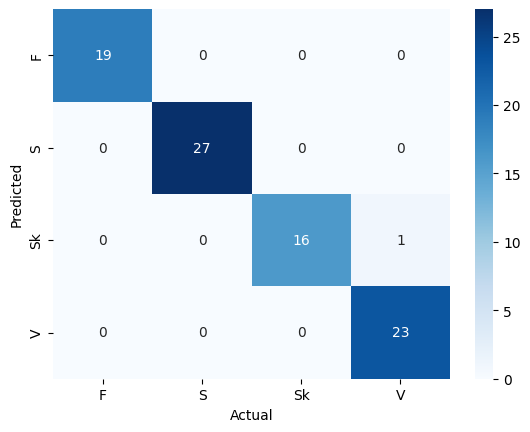

In [13]:


conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d',
            cmap='Blues',
            xticklabels=train_dataset.dataset.classes,
            yticklabels=train_dataset.dataset.classes)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig(Path(results_path) / 'train/confusion_matrix_vit.png')

In [14]:
torch.save(model, Path(results_path) / 'models/model_vit.pth')